In [2]:
from config import tiny_imagenet_config as config
from loader_util.preprocessing import ImageToArrayPreprocessor, \
    SimplePreProcessor, MeanPreprocessor
from loader_util.callbacks import TrainingMonitor, EpochCheckpoint
from loader_util.io import HDF5DatasetGenerator
from loader_util.nn.conv import DeeperGoogleNet

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import argparse
import json

In [6]:
model = DeeperGoogleNet.build(width=64,
                              height=64,
                              depth=3,
                              classes=config.NUM_CLASSES,
                              reg=0.0002)

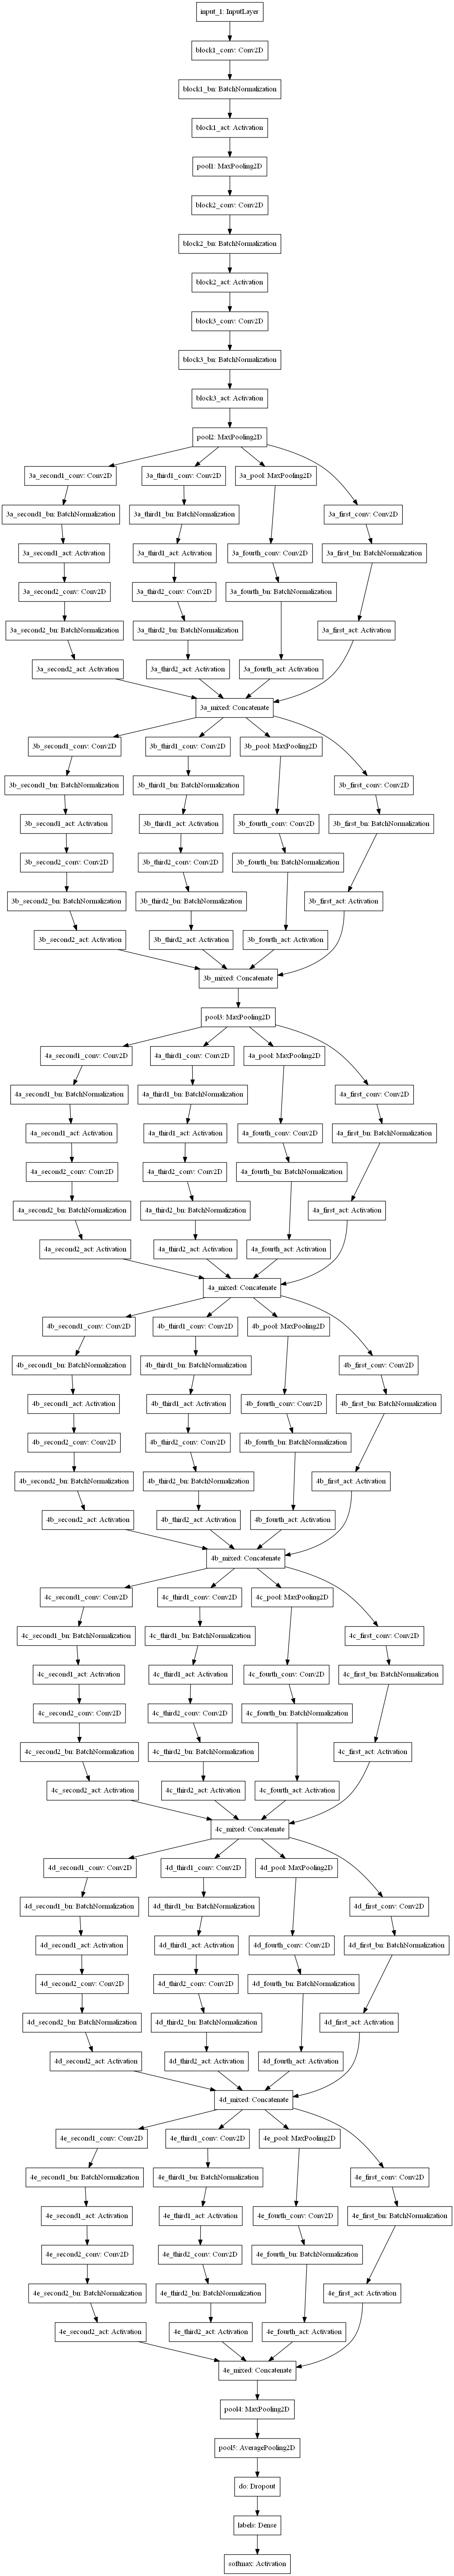

In [7]:
plot_model(model, "deep_google_net.png")

In [8]:
model.summary()

Model: "googlenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv (Conv2D)            (None, 64, 64, 64)   4864        input_1[0][0]                    
__________________________________________________________________________________________________
block1_bn (BatchNormalization)  (None, 64, 64, 64)   256         block1_conv[0][0]                
__________________________________________________________________________________________________
block1_act (Activation)         (None, 64, 64, 64)   0           block1_bn[0][0]                  
__________________________________________________________________________________________

In [4]:
# construct argument parser and parse the arguments
args = {
    "checkpoints": "",
    "model": "",
    "start_epoch": 0
}

In [5]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=18,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode='nearest')
# load the RGB means for the train set
means = json.loads(open(config.DATASET_MEAN).read())

FileNotFoundError: [Errno 2] No such file or directory: 'output/tiny-image-net-200-mean.json'

In [ ]:
# initialise the image preprocessors
sp = SimplePreProcessor(64,64)
mp = MeanPreprocessor(means['R'], means['G'], means['B'])
iap = ImageToArrayPreprocessor()

# init the train and valid dataset generators
trainGen = HDF5DatasetGenerator(dbPath=config.TRAIN_HDF5,
                                batchSize=64,
                                preprocessors=[sp, mp, iap],
                                aug=aug,
                                classes=config.NUM_CLASSES)

valGen = HDF5DatasetGenerator(dbPath=config.VAL_HDF5,
                              batchSize=64,
                              preprocessors=[sp, mp, iap],
                              classes=config.NUM_CLASSES)

In [ ]:
# if there is no specific model checkpoint supplied then init the network
if args['model'] is None:
    print('[INFO] compiling model.....')
    model = DeeperGoogleNet.build(width=64,
                                  height=64,
                                  depth=3,
                                  classes=config.NUM_CLASSES,
                                  reg=0.0002)
    opt = Adam(1e-3)
    model.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=['accuracy'])
else:
    # otherwise load checkpoint
    print(f'[INFO] loading {args["model"]}.....')
    model = load_model(args["model"])

    # update the leanring rate
    print(f"[INFO] old learning rate {K.get_value(model.optimizer.lr)}")
    K.set_value(model.optimizer.lr, 1e-5)
    print(f"[INFO] new learning rate : {K.get_value(model.optimizer.lr)}")

In [ ]:
# construct the set of callbacks
callbacks = [
    EpochCheckpoint(outputPath=args["checkpoints"], every=5,
                    startAt=args["start_epoch"]),
    TrainingMonitor(figPath=config.FIG_PATH, jsonPath=config.JSON_PATH,
                    startAt=args["start_epoch"])
]

In [ ]:
# train the network
model.fit_generator(generator=trainGen.generator(),
                    steps_per_epoch=trainGen.numImages // 64,
                    validation_data=valGen.generator(),
                    validation_steps=valGen.numImages // 64,
                    epochs=10,
                    max_queue_size=10,
                    callbacks=callbacks, verbose=1)

# close the databases
trainGen.close()
valGen.close()